# DeepSpectra model for NIR
Reproduction from the DeepSpectra model from Xiaolei Zhang's et al 2019 paper: https://doi.org/10.1016/j.aca.2019.01.002

**NOTE:** This is personal implementation of the the DeepSpectra model implemented in tensorflow.keras by dmpassos@ualg.pt<br> 
I follow up the original architecture depicted in the paper but there are a few ambiguities in the paper that I had to make some assumptions about. The dataset used for testing this implementation is the same as the one used in the paper (corn dataset, corn.mat, downloaded from Eigenvector website), but the original results are not fully reproduced. The original model was implemented in a different version of tensorflow (which has evolved a lot since 2019) and the original code is not available.

Use this model for your own experiments and research.


Last update: November 2025 (updated to tensorflow 2.20)


## Import libs


In [1]:
## Readjust cell width in Jupyter 
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:90% !important; }</style>"))


## Import main libraries
import os
from sys import stdout

import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd

import scipy.io as sio
from scipy import stats
from scipy.signal import savgol_filter
from tqdm import tqdm            # IMPORT THE CALLABLE
from tqdm.keras import TqdmCallback

from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score , KFold
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score 
from sklearn.model_selection import train_test_split

from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Conv1D,
    MaxPooling1D,
    Flatten,
    Dense,
    concatenate,
    LeakyReLU, 
    BatchNormalization,
    Dropout)

from tensorflow.keras.optimizers.schedules import InverseTimeDecay

from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model




2025-11-13 11:10:46.599961: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-13 11:10:46.932402: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-13 11:10:47.887307: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
## print tensorflow version
print("Tensorflow version: ", tf.__version__)

Tensorflow version:  2.20.0


## Help functions

In this section we define some help functions that will be use throughout the notebook. One of the biggest chuncks of code below is the "TQDM Progress Bar snippet" that allows us to have a progress bar runing while we train the model. This function was included in the tensorflow_addons library (tfa) which is no longer maintained. The code below is a copy of the original code from the tensorflow_addons library, so we can use it without having to install the library.

Function to define reproductible results

In [3]:
def reproducible_comp():
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(12345)
    random.seed(12345)
    tf.random.set_seed(12345)

reproducible_comp()

Function to optimize a PLS model (for comparison purposes)

In [4]:
def pls_optimization_cv_stop2(x_train, y_train, nmax=20, Nfolds=5, plot_opt=False, stop_criteria=0.01):
    """
    This function computes the optimal number of LVs for a PLS model using cross-validation using as stop criteria
    the LV that produces a gain in the CV RMSE lower than 1% of the previous LV.
    """
    ## List to store the CV RMSE for each LV
    cv_rmse=[]

    print('\nComputing optimal number of LVs for PLS model in the range 1 to {}...\n'.format(nmax))
    component = np.arange(1, nmax+1)
    previous_cv_rmse = None
    bestLV_stop = None
    
    print('Stop criteria: {}% gain in RMSE'.format(stop_criteria*100))

    for i in component:
        pls = PLSRegression(n_components=i, scale=True)
        cv_score=cross_val_score(pls, x_train, y_train, cv=KFold(Nfolds, shuffle = True, random_state=42),\
                        n_jobs=-1, scoring='neg_mean_squared_error', error_score=0)
        current_cv_rmse = np.round(np.sqrt(-np.mean(cv_score)),3)  
        ## Check if the current CV RMSE is less than 1% of the previous CV RMSE
        if (previous_cv_rmse is not None) and (current_cv_rmse <= np.min(cv_rmse)):
            percent_diff = abs((current_cv_rmse - previous_cv_rmse) / previous_cv_rmse)
            # print(f'Compute difference percentage between current LV={i} and previous LV={i-1} CV RMSE -> {np.round(percent_diff*100,3)}%')
            if percent_diff <= stop_criteria and bestLV_stop is None:               
                print(f"Stopping criteria reached, {np.round(percent_diff*100,3)}%. Saving component number.")
                ## The previous LV is the last one that adds more than 1% of gain in RMSE
                bestLV_stop = i-1 
                ## Save the RMSE of the previous LV
                RMSE_stop = previous_cv_rmse
        previous_cv_rmse = current_cv_rmse
        cv_rmse.append(current_cv_rmse)
        criterion_flag = '1% gain'

    ## if the 1% criteria returns no LV, then the bestLV_stop is the one where the RMSE is minimum
    if bestLV_stop is None:
        print(f'Stop criteria of {stop_criteria*100}% gain in RMSE not reached. Using minimum RMSE.')
        bestLV_stop = np.argmin(cv_rmse)+1
        RMSE_stop = np.min(cv_rmse)
        criterion_flag = 'minimum RMSE'
    
    RMSE_best = np.round(np.min(RMSE_stop),3)
    print(f'Suggested number of LV based on {Nfolds}-fold CV RMSE using {criterion_flag}: {bestLV_stop}')
    print(f'{Nfolds} CV RMSE: {RMSE_best}')
    stdout.write("\n")
    if plot_opt is True:
        plt.figure(figsize=(9,3))
        ax1=plt.subplot()
        ax1.plot(component[:len(cv_rmse)], np.array(cv_rmse), '-v', color = 'blue', mfc='blue')
        if bestLV_stop is not None:
            ax1.plot(component[bestLV_stop-1], [RMSE_best], 'P', ms=10, mfc='red',label='LV chosen')
        plt.xlabel('Number of PLS components')
        plt.ylabel('Mean of '+str(Nfolds)+'CV RMSE ')
        ax1.axvline(x=bestLV_stop, color='red', lw=1,linestyle='--')
        ax1.set_xticks(component)
        plt.xlim(0, nmax+1)
        # plt.title('# PLS components')
        plt.legend()
        plt.grid(alpha=0.33)
        plt.show()
    return bestLV_stop, RMSE_best

def pls_prediction_metrics(x_train, y_train, x_test, y_test, yname, lv, plot_pred=False):
    """
    USE: pls_prediction_metrics(x_train, y_train, x_test, y_test, yname, lv, plot_pred=False)
    """
    ## Define PLS with suggested optimal number of components and fit train data
    pls1 = PLSRegression(n_components=lv)
    
    ## Fit PLS model to train data
    pls1.fit(x_train, y_train)
    
    ## Get predictions for train and test sets
    y_train_pred = pls1.predict(x_train)
    y_test_pred = pls1.predict(x_test)
    
#     ########## diagnostics ###########
#     print(type(y_train.squeeze()), type(y_train_pred.squeeze()))
#     print(np.shape(y_train.squeeze()), np.shape(y_train_pred.squeeze()))
#     print(stats.pearsonr(y_train.squeeze(),y_train_pred.squeeze())[0]**2)
#     print(stats.pearsonr(y_train.squeeze(),y_train_pred.squeeze())[0]**2)
#     ########################
    
    ## Compute error metrics
    R2_train, RMSE_train, PG_train, CVAR_train=error_metrics(y_train,y_train_pred)
    R2_test, RMSE_test, PG_test, CVAR_test=error_metrics(y_test,y_test_pred)
    
    ## Print error metrics
    print('\nError metrics for best PLS model with LV = {}'.format(lv))
    print('METRIC \t TRAIN \t TEST')
    print('R2     \t {:0.3f}\t {:0.3f}'.format(R2_train,R2_test))
    print('RMSE   \t {:0.3f}\t {:0.3f}'.format(RMSE_train,RMSE_test))
    print('PG   \t {:0.3f}\t {:0.3f}'.format(PG_train,PG_test))
    print('CVAR   \t {:0.3f}\t {:0.3f}'.format(CVAR_train,CVAR_test))
    
    ## Plots: MSE vs. PLS LV and regression for best PLS model 
    # Get plot limits
    rangey = np.max(y_test) - np.min(y_test)
    rangex = np.max(y_test_pred) - np.min(y_test_pred)

    # x=y line and +- 1std upper and lower bowndaries
    xy_x=np.ravel([np.min(y_test)-0.1*rangex, np.max(y_test)+0.1*rangex])
    xy_y=np.ravel([np.min(y_test)-0.1*rangey, np.max(y_test)+0.1*rangey])
    if isinstance(x_train, pd.DataFrame):
        xy_y_up=xy_y+np.std(y_test.values)
        xy_y_down=xy_y-np.std(y_test.values)
    else:
        xy_y_up=xy_y+np.std(y_test)
        xy_y_down=xy_y-np.std(y_test)
   
    if plot_pred is True:
        ## linear fit to predicted test data
        plt.figure(figsize=(6,6))
        z = np.polyfit(np.ravel(y_test), np.ravel(y_test_pred), 1)
        ax = plt.subplot()
        ax.plot(xy_x, xy_y, 'k--', linewidth=2, label='y=x')
        plt.fill_between(xy_x, xy_y_down, xy_y_up, alpha=0.2)
        if isinstance(y_test,pd.DataFrame):
            ax.scatter(y_test.values,y_test_pred,c='gray',s=16, marker='o', alpha=0.66)
            ax.plot(y_test.values, z[1]+z[0]*y_test.values, c='navy', linewidth=3,label='linear fit')
        else:
            ax.scatter(y_test,y_test_pred,c='gray',s=16, marker='o', alpha=0.66)
            ax.plot(y_test, z[1]+z[0]*y_test, c='navy', linewidth=3,label='linear fit')
        plt.xlim(xy_x)
        plt.ylim(xy_y)
        plt.ylabel('Predicted '+yname, fontsize=12)
        plt.xlabel('Measured '+yname, fontsize=12)
#         plt.title(plot_name+': PLS',fontsize=14)
        plt.legend(loc=4)
        # Print the test error metrics on the plot
        plt.text(np.min(xy_x)+0.05*rangex, np.max(xy_y)-0.1*rangey, 'R$^{2}=$ %5.2f'  % R2_test, fontsize=13)
        plt.text(np.min(xy_x)+0.05*rangex, np.max(xy_y)-0.15*rangey, 'RMSE: %5.2f' % RMSE_test, fontsize=13)
        plt.text(np.min(xy_x)+0.05*rangex, np.max(xy_y)-0.2*rangey, 'PG: %5.2f' % PG_test, fontsize=13)
        plt.text(np.min(xy_x)+0.05*rangex, np.max(xy_y)-0.25*rangey, 'CVar: %5.2f%%' % CVAR_test, fontsize=13)
        plt.show()    
    return y_train_pred, y_test_pred, pls1

def error_metrics(y_true0, y_pred0):
    y_true=np.ravel(y_true0)
    y_pred=np.ravel(y_pred0)
    ## R squared R2 (based on the Pearson correlation) 
    R2 = stats.pearsonr(y_true.squeeze(),y_pred.squeeze())[0]**2
    ## Root Mean Squared Error (RMSE)
    RMSE = np.sqrt(mean_squared_error(y_true, y_pred))
    ## Prediction Gain (PG)
     # initialize PG vector with the mean value
    PG0 = np.zeros(len(y_pred)) + np.mean(y_true)
     # Now we compute the rms error between this preciction (mean value) and the validation set
    PG0_MSE= np.sqrt(mean_squared_error(y_true, PG0))
    PG= PG0_MSE / RMSE    
    ## Coefficient of Variation (CVAR) 
    CVAR = np.round(100.*RMSE/np.mean(y_true),2)
    return R2, RMSE, PG, CVAR


## Function to compute metrics and make prediction plots using train and test data
def plot_prediction2(Y_train, Y_test, Y_train_pred, Y_test_pred, title, savefig=False, figname=None):
    
    ## Compute train error scores 
    score_p0 = r2_score(Y_train, Y_train_pred)
    mse_p0 = mean_squared_error(Y_train, Y_train_pred)
    rmse_p0 = np.sqrt(mse_p0)
           
    ## Compute test error scores 
    score_p2 = r2_score(Y_test, Y_test_pred)
    mse_p2 = mean_squared_error(Y_test, Y_test_pred)
    rmse_p2 = np.sqrt(mse_p2)
  
    print('ERROR METRICS: \t TRAIN  \t\t TEST')
    print('------------------------------------------------------')
    print('R2:   \t\t %5.3f  \t\t %5.3f'  % (score_p0, score_p2 ))
    print('RMSE: \t\t %5.3f  \t\t %5.3f' % (rmse_p0, rmse_p2)) 
 
    #### Plot regression for model predicted data
    ## Get plot limits
    Y = np.concatenate([Y_train, Y_test])

    rangey = np.max(Y) - np.min(Y)
    rangex = np.max(Y) - np.min(Y)
    ## x=y line and +- 1std upper and lower bowndaries
    xy_x=np.ravel([np.min(Y)-0.1*rangex, np.max(Y)+0.1*rangex])
    xy_y=np.ravel([np.min(Y)-0.1*rangey, np.max(Y)+0.1*rangey])

    plt.figure(figsize=(5,5))
    z = np.polyfit(np.ravel(Y_test), np.ravel(Y_test_pred), 1)
    print('Fit result: Y=',z[1], ' + ', z[0],' * X')
    ax = plt.subplot(aspect=1)
    ax.plot(xy_x, xy_y, 'k--', linewidth=2, label=None)
    ax.scatter(Y_train, Y_train_pred, c='gray', marker='o', s=20, alpha=0.66, label='train')
    ax.scatter(Y_test,Y_test_pred, s=40, marker='o', facecolors='None', edgecolors='r', label='test')
    # Calculate the range of x-axis based on Y_train and Y_test
    x_min = min(np.min(Y_train), np.min(Y_test))
    x_max = max(np.max(Y_train), np.max(Y_test))
    # Create an array spanning the range of x-axis
    x_range = np.linspace(x_min, x_max, num=100)
    ax.plot(x_range, z[1]+z[0]*x_range, c='blue', linewidth=2,label='linear fit')
    plt.xlim(xy_x)
    plt.ylim(xy_y)
    # ax.plot(x_range, x_range, 'k--', linewidth=1.5, label='y=x')
    plt.ylabel('Predicted')
    plt.xlabel('Measured')
    plt.title(title)
    plt.legend(loc=4, frameon=False)
    
    # Print the scores on the plot
    plt.text(np.min(xy_x)+0.05*rangex, np.max(xy_y)-0.1*rangey, 'R$^{2}=$ %5.2f'  % score_p2, fontsize=13)
    plt.text(np.min(xy_x)+0.05*rangex, np.max(xy_y)-0.15*rangey, 'RMSE: %5.2f' % rmse_p2, fontsize=13)
    if savefig==True:
        plt.savefig(figname, dpi=150)
        print('Figure saved')
    else:    
        plt.show() 
    return 



In [5]:
## Function to compute metrics and make prediction plots using train and test data
def plot_prediction2(Y_train, Y_test, Y_train_pred, Y_test_pred, title, savefig=False, figname=None):

    ## Compute train error scores
    score_p0 = r2_score(Y_train, Y_train_pred)
    mse_p0 = mean_squared_error(Y_train, Y_train_pred)
    rmse_p0 = np.sqrt(mse_p0)

    ## Compute test error scores
    score_p2 = r2_score(Y_test, Y_test_pred)
    mse_p2 = mean_squared_error(Y_test, Y_test_pred)
    rmse_p2 = np.sqrt(mse_p2)

    print('ERROR METRICS: \t TRAIN  \t\t TEST')
    print('------------------------------------------------------')
    print('R2:   \t\t %5.3f  \t\t %5.3f'  % (score_p0, score_p2 ))
    print('RMSE: \t\t %5.3f  \t\t %5.3f' % (rmse_p0, rmse_p2))

    #### Plot regression for model predicted data
    ## Get plot limits
    Y = np.concatenate([Y_train, Y_test])

    rangey = np.max(Y) - np.min(Y)
    rangex = np.max(Y) - np.min(Y)
    ## x=y line and +- 1std upper and lower bowndaries
    xy_x=np.ravel([np.min(Y)-0.1*rangex, np.max(Y)+0.1*rangex])
    xy_y=np.ravel([np.min(Y)-0.1*rangey, np.max(Y)+0.1*rangey])

    plt.figure(figsize=(5,5))
    z = np.polyfit(np.ravel(Y_test), np.ravel(Y_test_pred), 1)
    print('Fit result: Y=',z[1], ' + ', z[0],' * X')
    ax = plt.subplot(aspect=1)
    ax.plot(xy_x, xy_y, 'k--', linewidth=2, label=None)
    ax.scatter(Y_train, Y_train_pred, c='gray', marker='o', s=20, alpha=0.66, label='train')
    ax.scatter(Y_test,Y_test_pred, s=40, marker='o', facecolors='None', edgecolors='r', label='test')
    # Calculate the range of x-axis based on Y_train and Y_test
    x_min = min(np.min(Y_train), np.min(Y_test))
    x_max = max(np.max(Y_train), np.max(Y_test))
    # Create an array spanning the range of x-axis
    x_range = np.linspace(x_min, x_max, num=100)
    ax.plot(x_range, z[1]+z[0]*x_range, c='blue', linewidth=2,label='linear fit')
    plt.xlim(xy_x)
    plt.ylim(xy_y)
    # ax.plot(x_range, x_range, 'k--', linewidth=1.5, label='y=x')
    plt.ylabel('Predicted')
    plt.xlabel('Measured')
    plt.title(title)
    plt.legend(loc=4, frameon=False)

    # Print the scores on the plot
    plt.text(np.min(xy_x)+0.05*rangex, np.max(xy_y)-0.1*rangey, 'R$^{2}=$ %5.2f'  % score_p2, fontsize=13)
    plt.text(np.min(xy_x)+0.05*rangex, np.max(xy_y)-0.15*rangey, 'RMSE: %5.2f' % rmse_p2, fontsize=13)
    if savefig==True:
        plt.savefig(figname, dpi=150)
        print('Figure saved')
    else:
        plt.show()
    return rmse_p0, rmse_p2

## Load the corn dataset

In [6]:
data = sio.loadmat('corn.mat')
data.keys()

data['information']

array(['This data set consists of 80 samples of corn measured on    ',
       '3 different NIR spectrometers. The wavelength range is      ',
       '1100-2498nm at 2 nm intervals (700 channels). The moisture, ',
       'oil, protein and starch values for each of the samples is   ',
       'also included. A number of NBS glass standards were also    ',
       'measured on each instrument. The data was originally taken  ',
       'at Cargill. Many thanks for Mike Blackburn for letting us   ',
       'distribute it.                                              ',
       '                                                            ',
       'The variables in this data set are described below:         ',
       '   information: [20x59  char  ] This field                  ',
       '        m5spec: [80x700 dataset] Spectra on instrument m5   ',
       '       mp5spec: [80x700 dataset] Spectra on instrument mp5  ',
       '       mp6spec: [80x700 dataset] Spectra on instrument mp6  ',
      

Following the methodology presented in the paper, we have to subsample the samples from the different spectrometers.
This is a point of difference from the original implementation, which used used a different set of random samples that we can not reproduce.

In [7]:
## Choose indexes corresponding to 27 random samples from the 80 samples, then another 27 samples from the remaining 53 samples and finally the last 26 samples
ind1 = np.random.choice(np.arange(80), size=27, replace=False)
ind2 = np.random.choice(np.setdiff1d(np.arange(80), ind1), size=27, replace=False)
ind3 = np.setdiff1d(np.arange(80), np.concatenate([ind1, ind2]))

## concatenate the random indices to used for the y values
ind_all = np.concatenate([ind1, ind2, ind3])

## the Y targets
y = pd.DataFrame(data['propvals'][0][0][7], columns=['moisture','oil', 'protein','starch']).loc[ind_all]

## the spectra from the 3 different spectrometers are selected based on the indices above
x1 = pd.DataFrame(data['m5spec'][0][0][7], columns=data['m5spec'][0][0][9][1][0][0]).loc[ind1]
x2 = pd.DataFrame(data['mp5spec'][0][0][7], columns=data['mp5spec'][0][0][9][1][0][0]).loc[ind2]
x3 = pd.DataFrame(data['mp6spec'][0][0][7], columns=data['mp6spec'][0][0][9][1][0][0]).loc[ind3]

## Concatenate all the x spectra into a single x DataFrame
x = pd.concat([x1, x2, x3], axis=0)

In [8]:
## Split x and y intro training (n=60) and and testing sets (n=20). We define the 'protein' column as the target variable.
x_train, x_test, y_train, y_test = train_test_split(x, y['protein'], test_size=20, random_state=42)

In [9]:
def standardize_column(X_train, X_test):
    ## We train the scaler on the full train set and apply it to the other datasets
    scaler = StandardScaler().fit(X_train)
    # scaler = MinMaxScaler().fit(X_train)
    ## for columns we fit the scaler to the train set and apply it to the test set
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return [X_train_scaled, X_test_scaled]

## standardize feature-wise using the statistics of the calibration set 
x_train_scaled, x_test_scaled = standardize_column(x_train, x_test)

## PLS modeling
As a way of having something to compared DeepSpectra with, we will use a PLS moded has baseline (but not optimizing for the type of preprocessing, which will harm PLS performance).


Computing optimal number of LVs for PLS model in the range 1 to 20...

Stop criteria: 1.0% gain in RMSE


Stop criteria of 1.0% gain in RMSE not reached. Using minimum RMSE.
Suggested number of LV based on 5-fold CV RMSE using minimum RMSE: 15
5 CV RMSE: 0.158



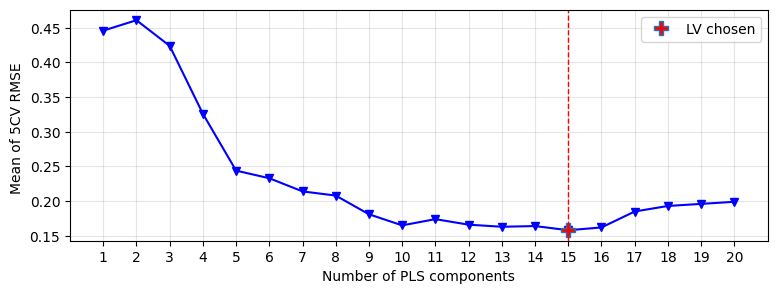

Best LV: 15, RMSE: 0.158
ERROR METRICS: 	 TRAIN  		 TEST
------------------------------------------------------
R2:   		 0.937  		 0.961
RMSE: 		 0.121  		 0.105
Fit result: Y= 0.11351362060556798  +  0.9851837550058412  * X


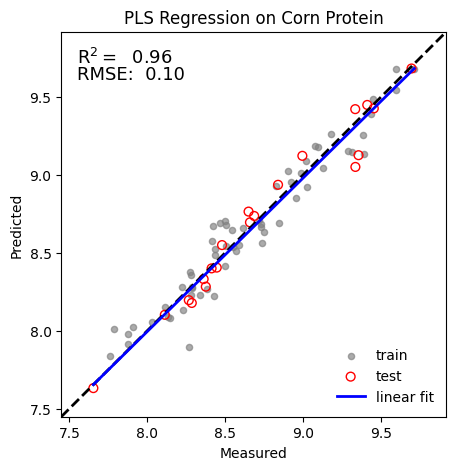

(np.float64(0.12077606638775099), np.float64(0.10462060389949568))

In [10]:
## compute PLS
bestLV, RMSE_best = pls_optimization_cv_stop2(x_train_scaled, y_train, nmax=20, Nfolds=5, plot_opt=True, stop_criteria=0.01)
print(f'Best LV: {bestLV}, RMSE: {RMSE_best}')


## NOTE: The automatic LV selection is 15, but by looking into the first plot below, we can see that LV=10 should be a good/better choice for generalization.
pls = PLSRegression(n_components=10, scale=False)
pls.fit(x_train_scaled, y_train.values)
y_train_pred = pls.predict(x_train_scaled)
y_test_pred = pls.predict(x_test_scaled)
plot_prediction2(y_train.values, y_test.values, y_train_pred, y_test_pred, title='PLS Regression on Corn Protein', savefig=False)

We now have our baseline RMSE of 0.1 for the PLS (without any preprocessing steps tested).

## DeepSpectra model

Implementation of the model as described in the paper.

In [11]:
def deepspectra_model(input_vector_dimension, 
                        kernel_size_1, 
                        kernel_size_2, 
                        kernel_size_3,
                        stride_1, 
                        stride_2, 
                        hidden_number, 
                        dropout_rate,
                        l2_regularization):
    """
    Builds the DeepSpectra CNN model as described in the paper.
    Analytica Chimica Acta 1058 (2019) 48-57. 
    Implementation by: D.Passos (dmpassos@uagl.pt)
    Args:
        input_vector_dimension (int): The number of features in the input spectra.
        kernel_size_1 (int): Kernel size for the first convolutional layer (Conv1).
        kernel_size_2 (int): Kernel size for the second main branch of the Inception module.
        kernel_size_3 (int): Kernel size for the third main branch of the Inception module.
        stride_1 (int): Stride for the first convolutional layer (Conv1).
        stride_2 (int): Stride for the parallel branches in the Inception module.
        hidden_number (int): Number of neurons in the fully connected layer (F1).
        dropout_rate (float): The dropout rate to be applied.
        l2_regularization (float): The L2 regularization factor.

    Returns:
        tensorflow.keras.Model: The compiled Keras DeepSpectra model.
    """
    
    # Define common layer parameters
    kernel_initializer = tf.keras.initializers.HeNormal(seed=12345)
    kernel_regularizer = l2(l2_regularization)
    
    # Input layer expects 3D tensor of shape (batch_size, steps, channels)
    # and channels=1.
    input_layer = Input(shape=(input_vector_dimension, 1))

    # Layer Conv1
    # Paper specifies 8 filters for this layer.
    conv1 = Conv1D(filters=8,
                   kernel_size=kernel_size_1,
                   strides=stride_1,
                   padding='same',
                   kernel_initializer=kernel_initializer,
                   kernel_regularizer=kernel_regularizer)(input_layer)
    conv1 = LeakyReLU()(conv1)

    # --- Inception Module ---
    # According to Figure 1, each of the 4 branches outputs 4 filters.
    # We will also use 4 filters for the reduction layers.
    num_inception_filters = 4

    # Branch 1: 1x1 Convolution
    tower_1 = Conv1D(filters=num_inception_filters,
                     kernel_size=1,
                     strides=stride_2,
                     padding='same',
                     kernel_initializer=kernel_initializer,
                     kernel_regularizer=kernel_regularizer)(conv1)
    tower_1 = LeakyReLU()(tower_1)

    # Branch 2: 1x1 Conv -> 3x1 Conv (or kernel_size_2)
    tower_2 = Conv1D(filters=num_inception_filters,
                     kernel_size=1,
                     strides=1, # Reduction layer has stride 1
                     padding='same',
                     kernel_initializer=kernel_initializer,
                     kernel_regularizer=kernel_regularizer)(conv1)
    tower_2 = LeakyReLU()(tower_2)
    tower_2 = Conv1D(filters=num_inception_filters,
                     kernel_size=kernel_size_2,
                     strides=stride_2,
                     padding='same',
                     kernel_initializer=kernel_initializer,
                     kernel_regularizer=kernel_regularizer)(tower_2)
    tower_2 = LeakyReLU()(tower_2)

    # Branch 3: 1x1 Conv -> 5x1 Conv (or kernel_size_3)
    tower_3 = Conv1D(filters=num_inception_filters,
                     kernel_size=1,
                     strides=1, # Reduction layer has stride 1
                     padding='same',
                     kernel_initializer=kernel_initializer,
                     kernel_regularizer=kernel_regularizer)(conv1)
    tower_3 = LeakyReLU()(tower_3)
    tower_3 = Conv1D(filters=num_inception_filters,
                     kernel_size=kernel_size_3,
                     strides=stride_2,
                     padding='same',
                     kernel_initializer=kernel_initializer,
                     kernel_regularizer=kernel_regularizer)(tower_3)
    tower_3 = LeakyReLU()(tower_3)

    # Branch 4: Max Pooling -> 1x1 Conv
    tower_4 = MaxPooling1D(pool_size=3,
                           strides=stride_2,
                           padding='same')(conv1)
    tower_4 = Conv1D(filters=num_inception_filters,
                     kernel_size=1,
                     strides=1, # Conv after pool has stride 1
                     padding='same',
                     kernel_initializer=kernel_initializer,
                     kernel_regularizer=kernel_regularizer)(tower_4)
    tower_4 = LeakyReLU()(tower_4)

    # Concatenate the outputs of the Inception module branches
    inception_output = concatenate([tower_1, tower_2, tower_3, tower_4], axis=-1)

    # --- Fully Connected Stage ---
    
    # Flatten layer
    flatten_layer = Flatten()(inception_output)

    # Batch Normalization and Dropout after Flatten
    bn1 = BatchNormalization()(flatten_layer)
    dropout1 = Dropout(dropout_rate)(bn1)
   
    
    # F1 Layer (Dense)
    f1 = Dense(units=hidden_number,
               kernel_initializer=kernel_initializer,
               kernel_regularizer=kernel_regularizer)(dropout1)
    f1 = LeakyReLU()(f1)

    # Batch Normalization and Dropout after F1
    bn2 = BatchNormalization()(f1)
    dropout2 = Dropout(dropout_rate)(bn2)

    # Output Layer (1 neuron for regression, linear activation)
    output_layer = Dense(units=1)(dropout2)
    output_layer = LeakyReLU()(output_layer) # Using LeakyReLU as per the paper, but could also use linear activation!

    # Create and return the model
    model = Model(inputs=input_layer, outputs=output_layer, name='DeepSpectra')
    
    return model


# # Use hyperparameters for the 'Corn' dataset from Table 1 in the paper.
# if __name__ == '__main__':
#     # Hyperparameters from Table 1 for the 'Corn' dataset
#     INPUT_DIM = 700      # From Table 2, #features for Corn
#     KERNEL_SIZE_1 = 7
#     KERNEL_SIZE_2 = 3
#     KERNEL_SIZE_3 = 5
#     STRIDE_1 = 3
#     STRIDE_2 = 2
#     HIDDEN_NUMBER = 16
#     DROPOUT_RATE = 0.2
#     L2_REG = 0.001
    
#     # Build the model
#     model = deepspectra_model(
#         input_vector_dimension=INPUT_DIM,
#         kernel_size_1=KERNEL_SIZE_1,
#         kernel_size_2=KERNEL_SIZE_2,
#         kernel_size_3=KERNEL_SIZE_3,
#         stride_1=STRIDE_1,
#         stride_2=STRIDE_2,
#         hidden_number=HIDDEN_NUMBER,
#         dropout_rate=DROPOUT_RATE,
#         l2_regularization=L2_REG
#     )

#     # Print the model summary to verify the architecture
#     model.summary()

Train the model with the same hyperparameter as shown in the paper. Notice that the authors do no mention the number of epoch that they used to train the model. We set this around 8000 based on tests performed on a PC with the same specs as the one used in the paper and the training time reported. This is a typical behavior for large models on small datasets. We need to pass the data multiple times through the model to get a good fit (at the risk of overfitting). 

Back in 2019, the authors reported using Keras (probably around version 2.3). In that implementation, Adam admited a learning rate decay, which is not the case in the current version of keras. The old decay argument on Adam (which used to implement simple inverse‑time LR decay) has been dropped in the current version of tf.keras. Therefore, we will implement directly a learning rate schedule to mimic the original implementation.

In [12]:
reproducible_comp()
## Clear keras session to avoid clutter from previous runs
keras.backend.clear_session()


## From Table 2, number of features for Corn data
INPUT_DIM = 700        

## Hyperparameters from Table 1 for the 'Corn' dataset 
KERNEL_SIZE_1 = 7
KERNEL_SIZE_2 = 3
KERNEL_SIZE_3 = 5
STRIDE_1 = 3
STRIDE_2 = 2
HIDDEN_NUMBER = 16
BATCH_SIZE = 32
DROPOUT_RATE = 0.2
L2_REG = 0.001
LR = 0.01
LR_DECAY = 0.001
EPOCHS = 8000 ## Extrapolated from training time reported in the paper


## Build the model
model1 = deepspectra_model(
    input_vector_dimension=INPUT_DIM,
    kernel_size_1=KERNEL_SIZE_1,
    kernel_size_2=KERNEL_SIZE_2,
    kernel_size_3=KERNEL_SIZE_3,
    stride_1=STRIDE_1,
    stride_2=STRIDE_2,
    hidden_number=HIDDEN_NUMBER,
    dropout_rate=DROPOUT_RATE,
    l2_regularization=L2_REG
)

lr_schedule = InverseTimeDecay(
    initial_learning_rate=LR,
    decay_steps=1, # This makes the decay apply per global step
    decay_rate=LR_DECAY
)

## Compile the model
model1.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='mean_squared_error',
              metrics=['mse'])

###### Callbacks ###################################
## Progressbar for visualization purposes only
progressbar = TqdmCallback(tqdm_class=tqdm, verbose=0)
## Including EarlyStopping callback to prevent overfitting but we don't know the stopping criteria from the paper.
## Also, the authors did not mention using any validation split for model training. Therefore, we will monitor the training loss.
## The patience is set to 500 epochs, which is quite high, but we will monitor the training loss.
early_stop = keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-5, patience=500, mode='auto', restore_best_weights=True, verbose=1)

## Train the model
history = model1.fit(
    x_train_scaled.reshape(-1, INPUT_DIM, 1),  # Reshape for Conv1D input
    y_train.values, shuffle=True, # Shuffle the training data in each pass
    # validation_split=0.1,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[progressbar, early_stop],
    verbose=0)

I0000 00:00:1763028203.058652 2965656 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9055 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5
  0%|          | 0/8000 [00:00<?, ?epoch/s]2025-11-13 10:03:25.054605: I external/local_xla/xla/service/service.cc:163] XLA service 0x758cb40027e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-13 10:03:25.054625: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2025-11-13 10:03:25.101547: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-13 10:03:25.305134: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
I0000 00:00:1763028207.114220 2966389 device_compiler.h:196] Compil

Restoring model weights from the end of the best epoch: 7530.


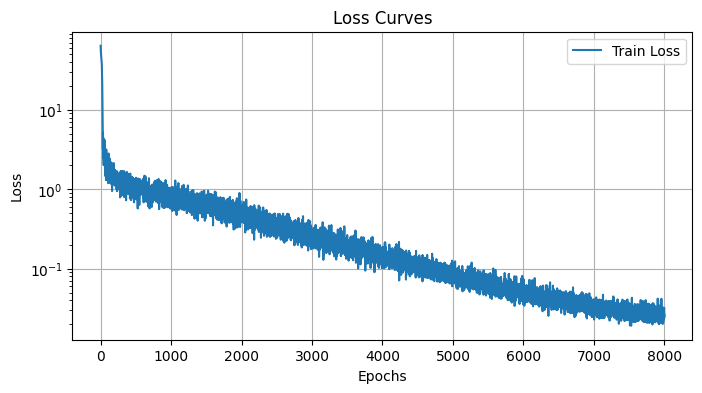

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
ERROR METRICS: 	 TRAIN  		 TEST
------------------------------------------------------
R2:   		 0.951  		 0.747
RMSE: 		 0.107  		 0.266
Fit result: Y= 2.2152857871924843  +  0.7479043200762396  * X


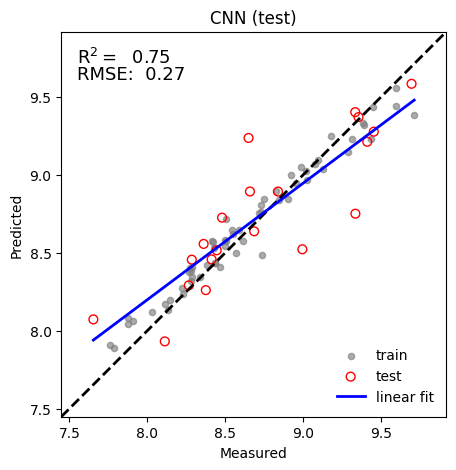

(np.float64(0.106660737765739), np.float64(0.2657048221950641))

In [13]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
# log y
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

## NOTE: EarlyStopping automatically load the best weights, so we don't need to do it manually.

## Compute RMSE metrics for TRAIN and TEST sets
y_train_pred = model1.predict(x_train_scaled)
y_test_pred = model1.predict(x_test_scaled)

plot_prediction2(y_train, y_test, y_train_pred, y_test_pred, 'CNN (test)', savefig=False, figname=None)

This result, Test RMSE = 0.266 do not even compare with the baseline PLS or even the RMSE = 0.12 reported in table 4 of the paper. Also, this method of training (without a validation split) is very prone to overfitting and that is pretty obvious that is happening here. That being said, please note that Adam and probably other optimizers were tweaked over time and therefore, some readjustment of the hyperparameters have to be done to mach the reported performance (plus hitting the right partition of the dataset, random seeds, etc.). *Since we are using shuffle=True, and we have a Dropout layer, the results will vary a bit from run to run.*

To explore this further and try to improve the results, I ran a Bayesian optimization loop  (done elsewhere) to optimize a couple of hyperparameters (the ones that most likely need to change due to algorithmic evolution since 2019), using 5-fold CV as objective function. One of the important parameters extracted from this optimization is the max number of epochs that we use o train the model. The value used is the average of the early stopping points across the folds. This prevents overfitting. We now used these hyperparamteres to train the model. 

In [23]:
reproducible_comp()
## Clear keras session to avoid clutter from previous runs
keras.backend.clear_session()


## Define the model hyperparameters
# Hyperparameters from Table 1 for the 'Corn' dataset
INPUT_DIM = 700      # From Table 2, #features for Corn
KERNEL_SIZE_1 = 7
KERNEL_SIZE_2 = 3
KERNEL_SIZE_3 = 5
STRIDE_1 = 3
STRIDE_2 = 2
HIDDEN_NUMBER = 16
BATCH_SIZE = 32
# EPOCHS = 10000  

## Hyperparameters from Bayesian optimization (Trial 150)
DROPOUT_RATE =  0.14
L2_REG = 0.0018000000000000002
LR = 0.004380537862726127
LR_DECAY = 0.00019105295443172917
EPOCHS = 6091 ## Extracted from EarlyStopping average of the 5-fold cv during Bayesian optimization



## Create the learning rate schedule
## For InverseTimeDecay: learning_rate = initial_learning_rate / (1 + decay_rate * step / decay_steps)
## To replicate the old Adam 'decay' behavior, we set decay_steps = 1.
## This makes the 'step' directly correspond to 'iterations'.
lr_schedule = InverseTimeDecay(
    initial_learning_rate=LR,
    decay_steps=1, # This makes the decay apply per global step
    decay_rate=LR_DECAY
)


## Build the model 
model2 = deepspectra_model(
    input_vector_dimension=INPUT_DIM,
    kernel_size_1=KERNEL_SIZE_1,
    kernel_size_2=KERNEL_SIZE_2,
    kernel_size_3=KERNEL_SIZE_3,
    stride_1=STRIDE_1,
    stride_2=STRIDE_2,
    hidden_number=HIDDEN_NUMBER,
    dropout_rate=DROPOUT_RATE,
    l2_regularization=L2_REG
)

## Compile the model
model2.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='mean_squared_error',
              metrics=['mse'])

## Callbacks
progressbar = TqdmCallback(tqdm_class=tqdm, verbose=0)
## NOTE: Do not use early stopping in the final model training. Just use it for hyperparameter tuning. Trust max epochs.
# early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-8, patience=1000, mode='auto', restore_best_weights=True, verbose=1)

## Train the model
history2 = model2.fit(
    x_train_scaled.reshape(-1, INPUT_DIM, 1),  # Reshape for Conv1D input
    y_train.values, shuffle=True, # Shuffle the training data
    # validation_split=0.1,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[progressbar], # No early_stop
    verbose=0
)


100%|██████████| 6091/6091 [02:47<00:00, 36.30epoch/s, loss=0.0574, mse=0.044] 


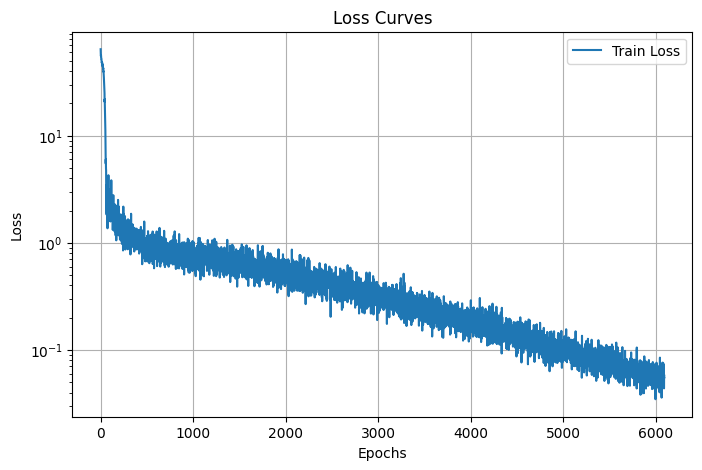

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
ERROR METRICS: 	 TRAIN  		 TEST
------------------------------------------------------
R2:   		 0.921  		 0.953
RMSE: 		 0.136  		 0.115
Fit result: Y= 1.369134703465927  +  0.8444997042474217  * X


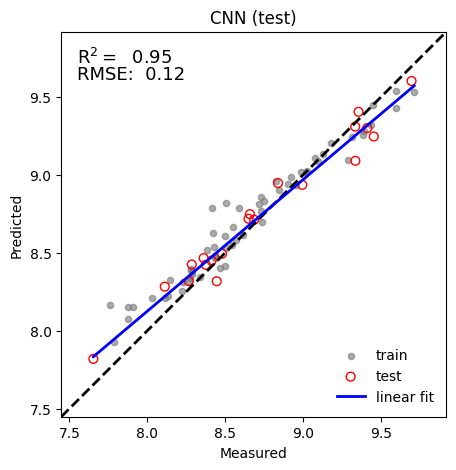

(np.float64(0.13564548485146324), np.float64(0.11505870964824898))

In [25]:
plt.figure(figsize=(8, 5))
plt.plot(history2.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
# log y
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# model.load_weights(model_name)
## Compute RMSE metrics for TRAIN and TEST sets
y_train_pred = model2.predict(x_train_scaled)
y_test_pred = model2.predict(x_test_scaled)

plot_prediction2(y_train, y_test, y_train_pred, y_test_pred, 'CNN (test)', savefig=False, figname=None)

We are able to aproximately reproduce the results reported in the paper, with a set of hyperparameters different than those reported originally. So in reality, when the model is properly optimized, it is able to deliver the performance reported. That being said, we still need to be careful with the results, since we are using a single partition of the dataset. We should run the model multiple times with different partitions and check for model stability.

### Experiments to perform next:
- Check the reproducibility / stability of the results by running the model with different partitions on the datasets.
- Check if a simpler CNN could get a similar performance ✅


Total parameters in this DeepSpectra: 37881


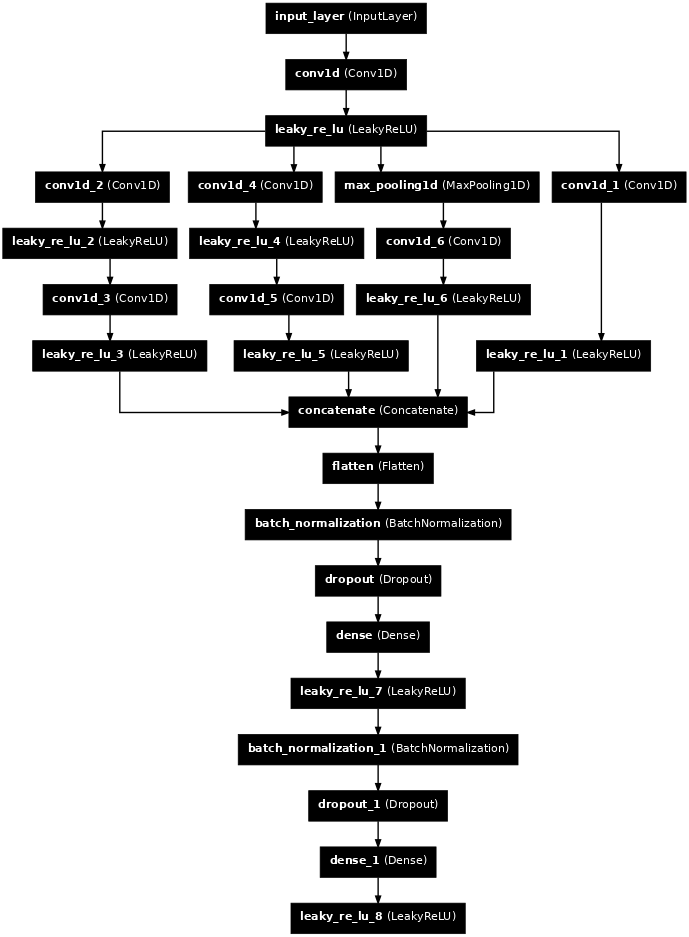

In [ ]:
## Print number of parameters in model2
print(f'Total parameters in this DeepSpectra: {model2.count_params()}')
## Plot model2 architecture
keras.utils.plot_model(model2, rankdir='TB', show_shapes=False, show_layer_names=True, dpi=50)

## Simple 1D-CNN 

Here I just implement a simple 1D-CNN architecture, based on CNN variant 1F from my Deep Tutti-Frutti paper. It uses 1 conv. layer with 1 filter, followed by 3 dense layers. There is also a skip connection from the input to the concatenate layer. No hyperparameter optimization was done and I use the same scheduler as for DeepSpectra. I define some of the hyperparameters based on the results that I got on the Deep Tutti-Frutti paper (where CNN_1F was optimized for dry matter prediction in a multifruit dataset), a totally different task and a few others based on intuition and the input dimensions.

In [10]:
## Define the model architecture using the Keras API
def create_model_1F(input_DIMS, num_CONV_layers, num_CONV_filters, filter_sizes, num_FC_layers, num_FC_units,  DROPOUT, reg_beta):
    ## Layers dimensions
    INPUT_DIMS = input_DIMS
    K_NUMBER = num_CONV_filters
    K_WIDTH = filter_sizes
    K_STRIDE = 1
    REG_OUTPUT_DIMS = 1
    
    ## Global (all layers) L2 regularizer parameter
    beta = reg_beta
    K_REG = tf.keras.regularizers.l2(beta)
    
    ## Weights initialization for multiple layers
    K_INIT = tf.keras.initializers.he_normal(seed=123)
    
    ## Architecture of the main model
    input_layer = layers.Input(shape=(INPUT_DIMS,), name='INPUT')
    x = layers.Reshape((INPUT_DIMS, 1))(input_layer)

    for i in range(0, num_CONV_layers):
        x = layers.Conv1D(
            filters=K_NUMBER[i],
            kernel_size=K_WIDTH[i],
            strides=K_STRIDE,
            padding='same',
            kernel_initializer=K_INIT,
            kernel_regularizer=K_REG,
            activation=None,  # No activation here
            name='CONVOLUTIONAL' + str(i)
        )(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('elu')(x)  # Apply activation after BatchNorm

    ## Flatten the output from the convolutional layers
    x = layers.Flatten(name='FLATTEN')(x)

    ## Add skip connection to input layer after flattening
    input_flat = layers.Flatten()(layers.Reshape((INPUT_DIMS, ))(input_layer))
    x = layers.Concatenate()([x, input_flat]) # skip connection

    for i in range(0, num_FC_layers):
        x = layers.Dense(num_FC_units[i], 
                         kernel_initializer=K_INIT, 
                         kernel_regularizer=K_REG,
                         activation='elu', 
                         name='DENSE'+str(i))(x)
        if i != num_FC_layers - 1:  # Only add dropout if it's not the last iteration
            x = layers.Dropout(DROPOUT[i], name='DROPOUT'+str(i))(x)

    
    # Regression output
    reg_output = layers.Dense(REG_OUTPUT_DIMS, 
                              kernel_initializer=K_INIT, 
                              activation='linear', 
                              name='REG_OUTPUT')(x)

    # Create the model with multiple outputs
    model_cnn = Model(inputs=input_layer, outputs=[reg_output], name='MODEL_CNN_V1F')
    
    return model_cnn

In [51]:
keras.backend.clear_session()
reproducible_comp()

## Define the model hyperparameters
# Hyperparameters from Table 1 for the 'Corn' dataset
INPUT_DIM = 700      # From Table 2, #features for Corn
BATCH_SIZE = 32      # Same as deepspectra
LR = 0.009 #0.001
EPOCHS = 10000
LR_DECAY = 0.001 #0.0001


# Build the regression model
model3 = create_model_1F(INPUT_DIM, 1, [1], [39], 3, [96,96,92], [0.1,0.1], 0.004)


lr_schedule = InverseTimeDecay(
    initial_learning_rate=LR,
    decay_steps=1, # This makes the decay apply per global step
    decay_rate=LR_DECAY
)

## Compile the model
model3.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='mean_squared_error',
              metrics=['mse'])

## Callbacks ###################################
progressbar = TqdmCallback(tqdm_class=tqdm, verbose=0)
early_stop = keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-5, patience=500, mode='auto', restore_best_weights=True, verbose=1)

## Train the model
history3 = model3.fit(
        x_train_scaled.reshape(-1, INPUT_DIM, 1),  # Reshape for Conv1D input
        y_train.values, shuffle=True, # Shuffle the training data
        # validation_split=0.2,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[progressbar, early_stop],
        verbose=0
    )

 89%|████████▉ | 8877/10000 [04:10<00:31, 35.39epoch/s, loss=0.0207, mse=0.00999]

Epoch 8877: early stopping
Restoring model weights from the end of the best epoch: 8377.


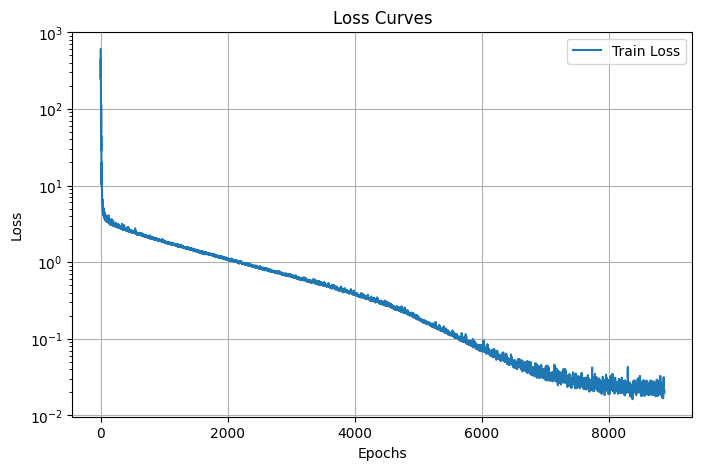

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
ERROR METRICS: 	 TRAIN  		 TEST
------------------------------------------------------
R2:   		 0.969  		 0.957
RMSE: 		 0.084  		 0.110
Fit result: Y= 0.4222988258444292  +  0.9489076647434502  * X


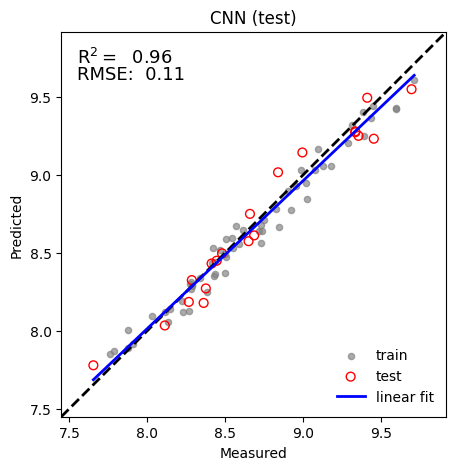

(np.float64(0.08424948296351836), np.float64(0.110198301006786))

In [52]:
plt.figure(figsize=(8, 5))
plt.plot(history3.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
# log y
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


# model.load_weights(model_name)
## Compute RMSE metrics for TRAIN and TEST sets
y_train_pred = model3.predict(x_train_scaled)
y_test_pred = model3.predict(x_test_scaled)

plot_prediction2(y_train, y_test, y_train_pred, y_test_pred, 'CNN (test)', savefig=False, figname=None)

!!! What can I say? Luck? Maybe!<br>
This was a quick test with no CNN hyperparameter optimization, using an architecture optimized for a different task and dataset and we get a RMSE of 0.11.
This makes me think that the parallel convolutional layers that DeepSpectra uses (in the inception module) do not really add much value for this specific dataset/task. A single conv. layer with just 1 filter (in the CNN) is able to extract enough features from the spectra to get a good performance. However this is done at the cost of a larger network with 3 dense hidden layers. Food for thought!!

Advise: Do your own experiments, and reach your own conclusions.

Total parameters in this CNN: 152869


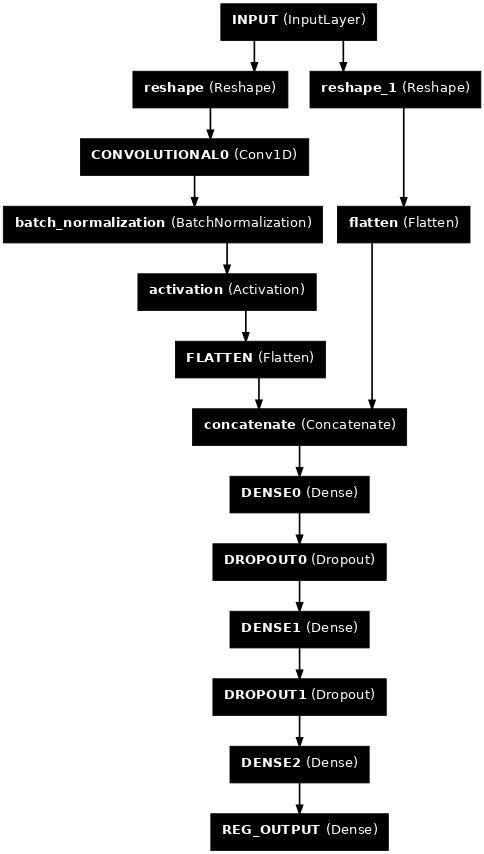

In [53]:
## Print number of parameters in model3
print(f'Total parameters in this CNN: {model3.count_params()}')
keras.utils.plot_model(model3, rankdir='TB', show_shapes=False, show_layer_names=True, dpi=60)

Another "quick" test: what happens if we remove the early stopping and just train the simple CNN for 30000 epochs with double the L2 regularization? Will it overfit badly? Or will it "grok" the data even better? For that we will also plot the test loss evolution along training.

 17%|█▋        | 5000/30000 [04:10<18:22, 22.68epoch/s, loss=0.2, mse=0.152, val_loss=0.276, val_mse=0.228]        


Epoch 5002: ReduceLROnPlateau reducing learning rate to 0.0013499999418854713.


 32%|███▏      | 9632/30000 [08:12<16:25, 20.66epoch/s, loss=0.034, mse=0.0205, val_loss=0.0403, val_mse=0.0272]   


Epoch 9634: ReduceLROnPlateau reducing learning rate to 0.00020249998779036104.


 39%|███▊      | 11580/30000 [09:56<2:04:34,  2.46epoch/s, loss=0.0159, mse=0.00718, val_loss=0.0205, val_mse=0.0117]


Epoch 11582: ReduceLROnPlateau reducing learning rate to 3.03749977319967e-05.


 54%|█████▍    | 16283/30000 [14:08<16:05, 14.21epoch/s, loss=0.0124, mse=0.00452, val_loss=0.0177, val_mse=0.00986]  


Epoch 16285: ReduceLROnPlateau reducing learning rate to 4.556249768938869e-06.


 59%|█████▉    | 17700/30000 [15:24<09:26, 21.73epoch/s, loss=0.0138, mse=0.00592, val_loss=0.0168, val_mse=0.00899]  


Epoch 17702: ReduceLROnPlateau reducing learning rate to 1e-06.


100%|██████████| 30000/30000 [26:31<00:00, 18.85epoch/s, loss=0.0122, mse=0.00439, val_loss=0.0166, val_mse=0.00885]  


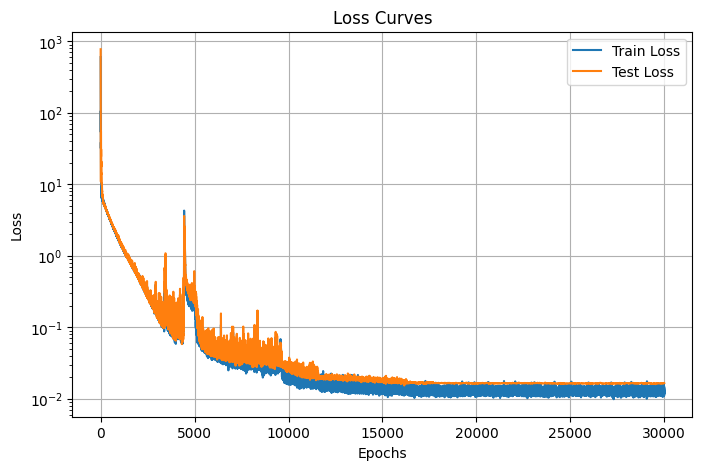

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
ERROR METRICS: 	 TRAIN  		 TEST
------------------------------------------------------
R2:   		 0.984  		 0.968
RMSE: 		 0.061  		 0.094
Fit result: Y= 0.2986030237770027  +  0.9676961481127214  * X


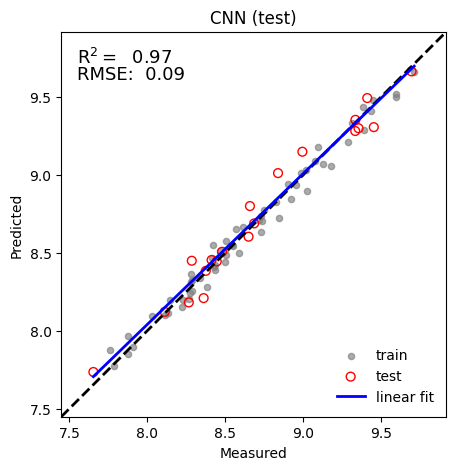

(np.float64(0.061077575327412016), np.float64(0.0940572876979682))

In [24]:
keras.backend.clear_session()
reproducible_comp()

## Define the model hyperparameters
# Hyperparameters from Table 1 for the 'Corn' dataset
INPUT_DIM = 700      # From Table 2, #features for Corn
BATCH_SIZE = 32      # Same as deepspectra
LR = 0.009 #0.001
EPOCHS = 30000
LR_DECAY = 0.001 #0.0001


# Build the regression model
model4 = create_model_1F(INPUT_DIM, 1, [1], [39], 3, [96,96,92], [0.1,0.1], 0.008)


# lr_schedule = InverseTimeDecay(
#     initial_learning_rate=LR,
#     decay_steps=2, # This makes the decay apply per global step
#     decay_rate=LR_DECAY
# )

## Compile the model
model4.compile(optimizer=keras.optimizers.Adam(learning_rate=LR),
              loss='mean_squared_error',
              metrics=['mse'])

## Callbacks ###################################
progressbar = TqdmCallback(tqdm_class=tqdm, verbose=0)
# early_stop = keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-5, patience=500, mode='auto', restore_best_weights=True, verbose=1)
lr_reduce = keras.callbacks.ReduceLROnPlateau(
    monitor='loss', factor=0.15, patience=1000,
    min_lr=1e-6, verbose=1
)

## Train the model
history4 = model4.fit(
        x_train_scaled.reshape(-1, INPUT_DIM, 1),  # Reshape for Conv1D input
        y_train.values, shuffle=True, # Shuffle the training data
        #validation_split=0.2,
        validation_data=(x_test_scaled.reshape(-1, INPUT_DIM, 1), y_test.values),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[progressbar, lr_reduce],
        verbose=0
    )


plt.figure(figsize=(8, 5))
plt.plot(history4.history['loss'], label='Train Loss')
plt.plot(history4.history['val_loss'], label='Test Loss')
plt.title('Loss Curves')
# log y
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


# model.load_weights(model_name)
## Compute RMSE metrics for TRAIN and TEST sets
y_train_pred = model4.predict(x_train_scaled)
y_test_pred = model4.predict(x_test_scaled)

plot_prediction2(y_train, y_test, y_train_pred, y_test_pred, 'CNN (test)', savefig=False, figname=None)

No signs of increased overfitting after 30000 epochs! The test RMSE is even slightly better than the previous run. This shows that regularization is doing a good job at preventing strong overfitting, even after a large number of epochs. Interesting!

Lets continue the previous run for another 30000 epochs (60000 in total) to see what happens.

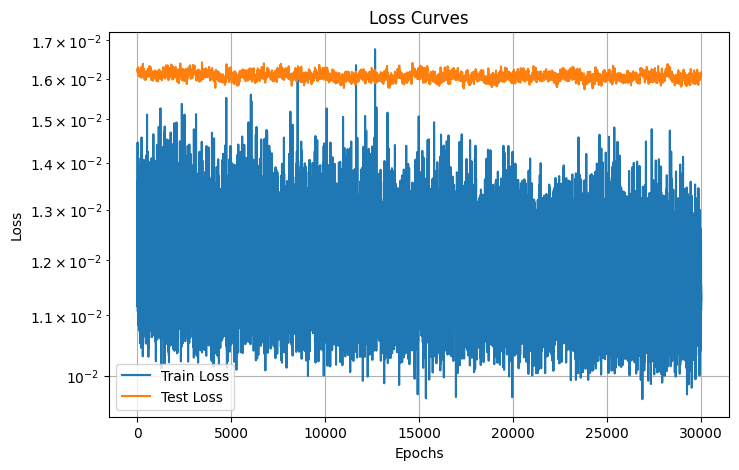

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
ERROR METRICS: 	 TRAIN  		 TEST
------------------------------------------------------
R2:   		 0.985  		 0.970
RMSE: 		 0.058  		 0.092
Fit result: Y= 0.20097000014274805  +  0.978807781959803  * X


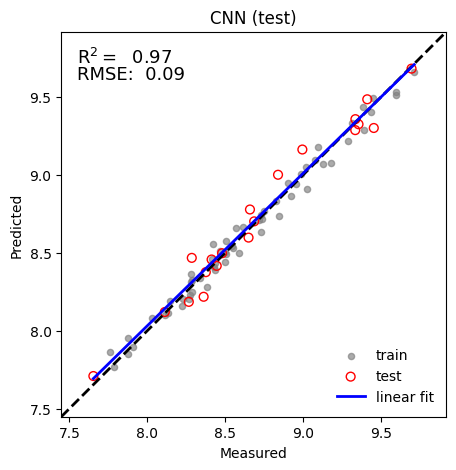

(np.float64(0.05838675466885865), np.float64(0.09228140975676499))

In [26]:
## Model not reinitialized. We continue training from previous state. The initial learning rate might be too high
EPOCHS = 30000
history5 = model4.fit(
        x_train_scaled.reshape(-1, INPUT_DIM, 1),  # Reshape for Conv1D input
        y_train.values, shuffle=True, # Shuffle the training data
        #validation_split=0.2,
        validation_data=(x_test_scaled.reshape(-1, INPUT_DIM, 1), y_test.values),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[progressbar, lr_reduce],
        verbose=0
    )


plt.figure(figsize=(8, 5))
plt.plot(history5.history['loss'], label='Train Loss')
plt.plot(history5.history['val_loss'], label='Test Loss')
plt.title('Loss Curves')
# log y
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


# model.load_weights(model_name)
## Compute RMSE metrics for TRAIN and TEST sets
y_train_pred = model4.predict(x_train_scaled)
y_test_pred = model4.predict(x_test_scaled)

plot_prediction2(y_train, y_test, y_train_pred, y_test_pred, 'CNN (test)', savefig=False, figname=None)